# Sensitivity analysis

See [Pascal's code](https://github.com/PascalLesage/GSA/blob/master/lca_gsa.py) for another global sensitivity analysis method linked to Brightway LCA calculations

In [1]:
import brightway2 as bw

In [2]:
from time import time

In [3]:
bw.projects.set_current("bw2_seminar_2017")

In [6]:
db = bw.Database("ecoinvent 2.2")

In [11]:
a = db.random()
print(a)

for x in a.technosphere():
    print(x['amount'], x['uncertainty type'], x['scale'], bw.mapping[x['input']], x.input)

'medium density fibreboard, at plant' (cubic meter, RER, ['wooden materials', 'extraction'])
4.36 2 0.07421000255913658 4273 'aluminium sulphate, powder, at plant' (kilogram, RER, ['chemicals', 'inorganics'])
22.8 2 0.07421000255913658 4458 'paraffin, at plant' (kilogram, RER, ['chemicals', 'organics'])
355.0 2 0.07421000255913658 4677 'electricity, medium voltage, production UCTE, at grid' (kilowatt hour, UCTE, ['electricity', 'production mix'])
1670.0 2 0.07421000255913658 5358 'natural gas, burned in industrial furnace >100kW' (megajoule, RER, ['natural gas', 'heating systems'])
49.6 2 0.07421000255913658 5600 'urea formaldehyde resin, at plant' (kilogram, RER, ['paintings', 'production'])
85.6 2 0.36858203298835984 5832 'transport, lorry >16t, fleet average' (ton kilometer, RER, ['transport systems', 'road'])
202.0 2 0.36858203298835984 5870 'transport, freight, rail' (ton kilometer, RER, ['transport systems', 'train'])


KeyError: 'scale'

In [12]:
m = ('CML 2001', 'climate change', 'GWP 500a')

In [13]:
pv = bw.ParameterVectorLCA({a.key: 1}, m)
next(pv)

538.0088522280367

In [15]:
index = bw.mapping[a]

ra, _, _ = pv.reverse_dict()

indices = []

for i, x in enumerate(pv.tech_params):
    if x['output'] == index:
        if x['output'] != x['input']:
            indices.append(i)
        print(i, bw.get_activity(ra[int(x['row'])]))

2316 'medium density fibreboard, at plant' (cubic meter, RER, ['wooden materials', 'extraction'])
6175 'aluminium sulphate, powder, at plant' (kilogram, RER, ['chemicals', 'inorganics'])
12663 'paraffin, at plant' (kilogram, RER, ['chemicals', 'organics'])
16515 'electricity, medium voltage, production UCTE, at grid' (kilowatt hour, UCTE, ['electricity', 'production mix'])
22961 'natural gas, burned in industrial furnace >100kW' (megajoule, RER, ['natural gas', 'heating systems'])
25320 'urea formaldehyde resin, at plant' (kilogram, RER, ['paintings', 'production'])
28927 'transport, lorry >16t, fleet average' (ton kilometer, RER, ['transport systems', 'road'])
31041 'transport, freight, rail' (ton kilometer, RER, ['transport systems', 'train'])
38243 'wood chips, softwood, from industry, u=40%, at plant' (cubic meter, RER, ['wood energy', 'fuels'])
38354 'wood chips, from industry, softwood, burned in furnace 300kW' (megajoule, CH, ['wood energy', 'heating systems'])
38453 'industrial

In [16]:
from bw2calc import ParameterVectorLCA, ParallelMonteCarlo
from scipy.stats import ks_2samp
from stats_arrays import uncertainty_choices
import multiprocessing
import numpy as np


def pawn_worker(args):
    fu, method, index, unconditional_cdf, n_c, n = args
    lca = ParameterVectorLCA(fu, method)
    lca.load_data()
    next(lca)
    array = lca.params[index:index + 1]
    lhc = (np.random.random(size=n) + np.arange(n)) / n
    n_samples = uncertainty_choices[int(array['uncertainty_type'][0])].ppf(
        array, lhc.reshape((1, -1))).ravel()
    results = []

    for fixed in n_samples:

        scores = []

        for _ in range(n_c):
            sample = lca.rng.next()
            sample[index] = fixed

            lca.rebuild_all(sample)
            lca.lci_calculation()
            lca.lcia_calculation()
            scores.append(lca.score)

        results.append(ks_2samp(unconditional_cdf, np.array(scores))[0])

    return (index, np.median(results))
    

def pawn_sensitivity(fu, method, indices, cpus=None, n_u=1000, n_c=100, n=20):
    unconditional_cdf = ParallelMonteCarlo(fu, method, n_u, cpus=cpus).calculate()

    with multiprocessing.Pool(processes=cpus) as pool:
        results = pool.map(
            pawn_worker,
            [(fu, method, index, unconditional_cdf.copy(), n_c, n) 
             for index in indices]
        )
    return results

In [17]:
def pawn_worker_full(args):
    fu, method, index, unconditional_cdf, n_c, n = args
    lca = ParameterVectorLCA(fu, method)
    lca.load_data()
    next(lca)
    array = lca.params[index:index + 1]
    lhc = (np.random.random(size=n) + np.arange(n)) / n
    n_samples = uncertainty_choices[int(array['uncertainty_type'][0])].ppf(
        array, lhc.reshape((1, -1))).ravel()
    results = []

    for fixed in n_samples:

        scores = []

        for _ in range(n_c):
            sample = lca.rng.next()
            sample[index] = fixed

            lca.rebuild_all(sample)
            lca.lci_calculation()
            lca.lcia_calculation()
            scores.append(lca.score)

        results.append(np.array(scores))

    return (index, results)
    

def pawn_sensitivity_full(fu, method, indices, cpus=None, n_u=1000, n_c=100, n=20):
    unconditional_cdf = ParallelMonteCarlo(fu, method, n_u, cpus=cpus).calculate()

    with multiprocessing.Pool(processes=cpus) as pool:
        results = pool.map(
            pawn_worker_full,
            [(fu, method, index, unconditional_cdf.copy(), n_c, n) 
             for index in indices]
        )
    return unconditional_cdf, results

In [18]:
%matplotlib inline

In [19]:
from matplotlib import pyplot as plt

In [20]:
empirical_cdf = lambda xs: np.linspace(0, 1, int(xs.shape[0]))

In [22]:
start = time()
unconditional_cdf, results = pawn_sensitivity_full({a.key: 1}, m, indices)
(time() - start) / 60

7.098225247859955

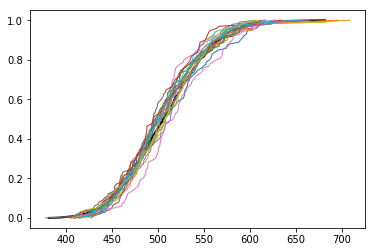

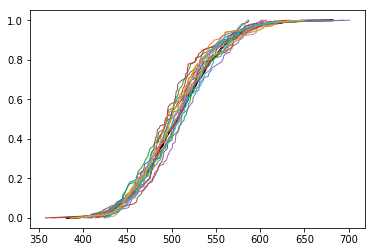

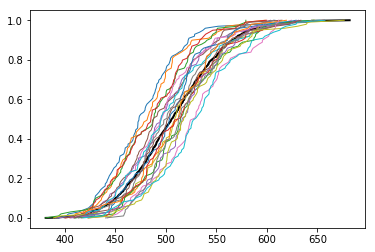

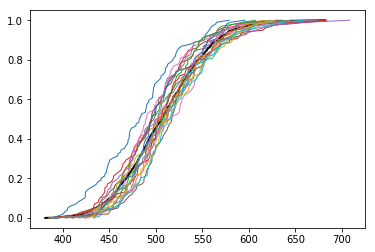

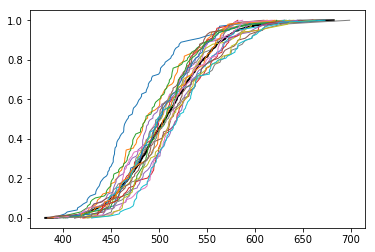

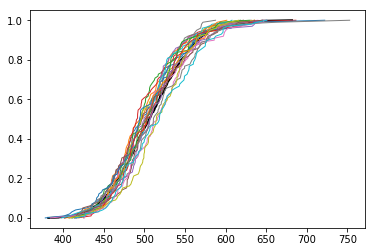

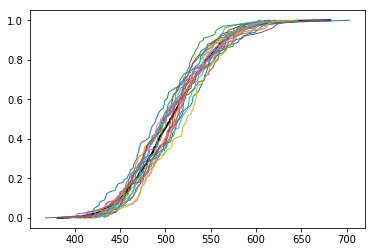

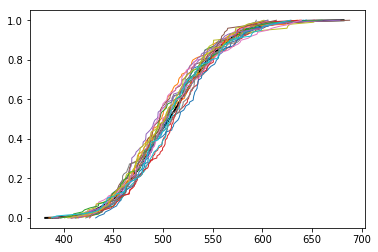

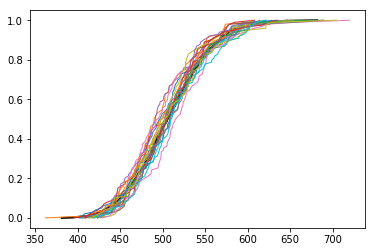

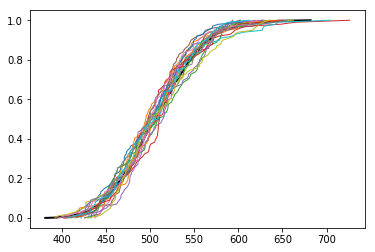

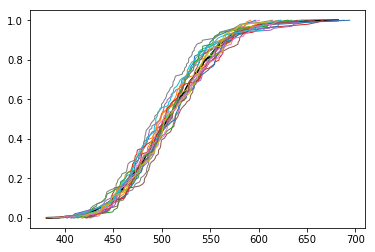

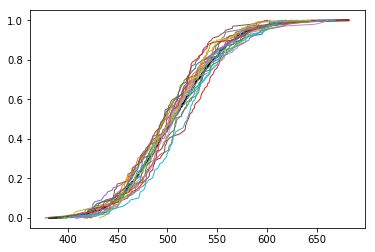

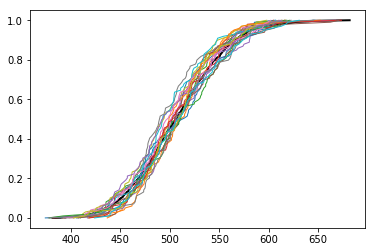

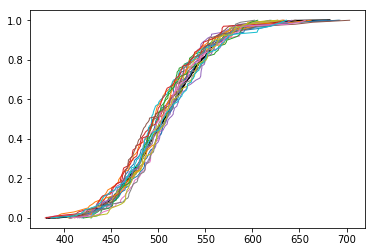

In [23]:
for index, conditional_cdfs in results:

    xs = np.sort(unconditional_cdf)
    plt.plot(xs, empirical_cdf(xs), lw=2, color='black')

    for ds in conditional_cdfs:
        ds = np.sort(ds)
        plt.plot(ds, empirical_cdf(ds), lw=1, ls='-')
    plt.show()

In [32]:
for index, conditional_cdfs in results:
    print(index, np.median([ks_2samp(unconditional_cdf, sample)[0] for sample in conditional_cdfs]))

28112 0.138154761905
33529 0.0980357142857
33565 0.0914285714286
36368 0.141527777778
